### 1.0 Import packages and adjust settings

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import xarray as xr
xr.set_options(display_style='text'); # Show xarray.Dataset representation as text

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10}) # Set plot font size to 16pt

import numpy as np
import time
from scipy.spatial import cKDTree
from pykrige import OrdinaryKriging as OKpy
import tqdm
import os
import pandas as pd
import matplotlib as mpl

# OPENSENSE Sandbox tools 
# ToDo: Set link from local to github
import PWSpyqcFunctions as pws_pyqc

# Link to the data
main_dir = r"https://raw.githubusercontent.com/AbbasElHachem/pws-pyqc/main/OpenSense/Data/"


PWSqc-QC specific settings 


In [3]:
# maximun distance (meters) for which the indicator correlation is calculated
max_distance = 50000

# Precentile threshold for indicator correlation 
prob=0.99

# todo: chekc if and where this is needed
show_plot = True

# minimum number of records (in hours) with values (here 2 months)
min_req_ppt_vals = 2*30*24 

### 1.1 Load the csv data files

In [4]:
# Automatic weather satation data from KNMI Netherlands
path_primary_network = os.path.join(main_dir, r"AWS_stns_data.csv")
path_primary_metadata = os.path.join(main_dir, r"AWS_stns_coords.csv")   

# Data from 20 randomly chose radar grid cells as "primary stations 2" for the Amsterdam area
path_primary_network2 = os.path.join(main_dir, r"Radar_grid_cell_vals.csv")
path_primary_metadata2 = os.path.join(main_dir, r"selected_radar_grid_lonlat.csv") 


# PWS hourly data ()
path_pws_data = os.path.join(main_dir, r"AMS_PWS_hourly_shifted.csv")   
path_pws_metadata = os.path.join(main_dir, r"AMS_metadata.csv")

**&#8594;** each datasets consists of a metafile with coordinates and a data file with stations as columns and timestamps as rows (c.f. OPENSENSE White Paper)

**&#8594;** the Netatmo PWS data set used here is published by de [Vos (2019)](https://data.4tu.nl/articles/_/12703250/1)

**&#8594;** `pyqc.read_pcp_csv_file` and `read_metadata_csv_file` in the following code are functions based on `pandas.DataFrame` 

If you are familiar with python functions you can have a look at the file **PWSpyqcFunctions.py**

In [5]:
# read primary network 1
print('Reading first primary network data')
# pyqc.read_pcp_csv_file has 'latin-1' encoding in PWSpyqcFunctions.py
in_primary_pcp = pws_pyqc.read_pcp_csv_file(path_to_file=path_primary_network,
                           sep_type=';',
                           index_col=0)

# pyqc uses EPSG:25832, for Netherlands EPSG:28531 is used!
# Reads coordinate file and additionally coverts Lat/Lon to UTM 32
df_prim_coords, prim_coords_xy = pws_pyqc.read_metadata_csv_file(path_primary_metadata,
                                                           sep_type=';', index_col=0,)
df_prim_coords.index = in_primary_pcp.columns
# read primary network 2
print('Reading secondary primary network data')
in_primary_pcp_2 = pws_pyqc.read_pcp_csv_file(path_to_file=path_primary_network2,
                           sep_type=';',
                           index_col=0)

df_prim_coords_2, prim_coords_xy_2 = pws_pyqc.read_metadata_csv_file(
            path_primary_metadata2,
            sep_type=',', index_col=0,)
df_prim_coords_2.index = in_primary_pcp_2.columns

# read pws data
print('Reading PWS data')
df_pws_pcp_hourly = pws_pyqc.read_pcp_csv_file(
        path_to_file=path_pws_data,
                           sep_type=';',
                           index_col=0)
    
df_pws_coords, pws_coords_xy = pws_pyqc.read_metadata_csv_file(
        path_to_file=path_pws_metadata,
                           sep_type=',',
                           index_col=0)
df_pws_coords.index = df_pws_pcp_hourly.columns

Reading first primary network data
Reading secondary primary network data
Reading PWS data


### 1.2 How do the data look like?

In [6]:
# This shows the PWS data itself as described above
df_pws_pcp_hourly.head()

,ams1,ams2,ams3,ams4,ams5,ams6,ams7,ams8,ams9,ams10,...,ams125,ams126,ams127,ams128,ams129,ams130,ams131,ams132,ams133,ams134
Time,,,,,,,,,,,,,,,,,,,,,
2016-05-01 01:00:00,0.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2016-05-01 02:00:00,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2016-05-01 03:00:00,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2016-05-01 04:00:00,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2016-05-01 05:00:00,0.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [7]:
df_pws_pcp_hourly.describe()

,ams1,ams2,ams3,ams4,ams5,ams6,ams7,ams8,ams9,ams10,...,ams125,ams126,ams127,ams128,ams129,ams130,ams131,ams132,ams133,ams134
count,15802.000000,14217.000000,15808.000000,10804.000000,12463.000000,13596.000000,16497.000000,15627.000000,11710.000000,1841.000000,...,10531.000000,13425.000000,14714.000000,11517.000000,1934.000000,1023.000000,3397.000000,8526.000000,8731.000000,16549.000000
mean,0.081290,0.089915,0.081764,0.100704,0.085097,0.106146,0.065988,0.099592,0.087868,0.155470,...,0.086023,0.137145,0.085362,0.110187,0.086396,0.053245,0.074342,0.084037,0.087354,0.092683
std,0.387545,0.426993,0.413551,0.464482,0.395962,0.551481,0.367549,0.482112,0.427031,0.635277,...,0.410645,0.949273,0.472458,0.544546,0.458758,0.317535,0.299455,0.516298,0.494587,0.547407
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,8.690000,15.660000,12.530000,13.430000,11.510000,16.470000,12.620000,13.430000,13.940000,8.180000,...,13.130000,41.210000,16.660000,21.510000,7.780000,5.350000,4.850000,13.840000,20.000000,20.300000


### 1.3 Plotting the data

### 1.3.1 Location of the stations

Plotting locations of all data


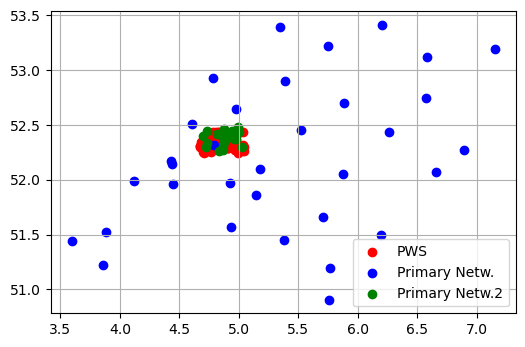

In [8]:
print('Plotting locations of all data')

pws_pyqc.plot_pws_prim_netz_loc(lon_pws=df_pws_coords.lon,
                       lat_pws=df_pws_coords.lat,
                      lon_prim1=df_prim_coords.lon,
                       lat_prim1=df_prim_coords.lat,
                      lon_prim2=df_prim_coords_2.lon,
                       lat_prim2=df_prim_coords_2.lat)

    


Plotting locations of data in and around Amsterdam


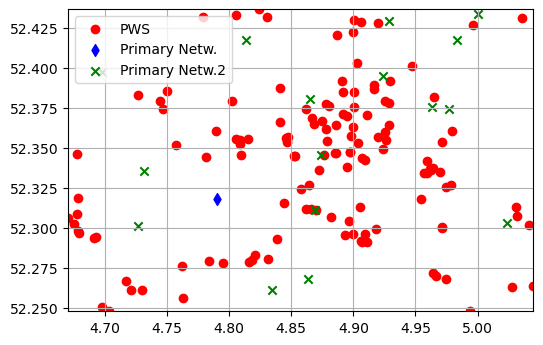

In [9]:
print('Plotting locations of data in and around Amsterdam')

pws_pyqc.plot_pws_prim_netz_loc_AMS(lon_pws=df_pws_coords.lon,
                                    lat_pws=df_pws_coords.lat,
                                    lon_prim1=df_prim_coords.lon,
                                    lat_prim1=df_prim_coords.lat,
                                    lon_prim2=df_prim_coords_2.lon,
                                    lat_prim2=df_prim_coords_2.lat)

### 1.3.2 Plotting the PWS data

<AxesSubplot:xlabel='Time', ylabel='mm'>

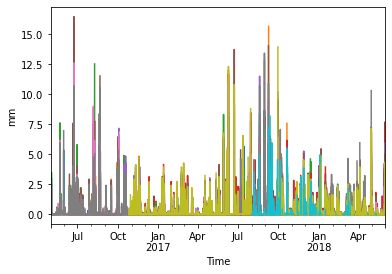

In [12]:
# Plotting first 10 stations
df_pws_pcp_hourly.iloc[:,:10].plot(legend=False, ylabel='mm')

This does not really make sense with 134 stations.

+ What is the first thing we can observe here?

### Let's plot some individual stations

<AxesSubplot:title={'center':'PWS ams18'}, xlabel='Time', ylabel='mm'>

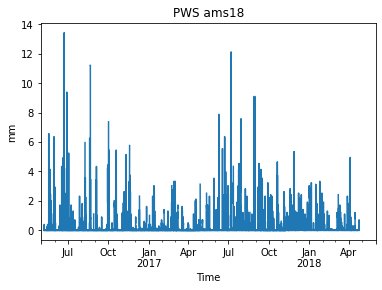

In [14]:
# PWS station ams18
df_pws_pcp_hourly['ams18'].plot(ylabel='mm', title='PWS ams18')


## 2. First PWSpy-QC step: Indicator correlation based filter
The fist QC-filter of PWS-pyqc is based on indicator correlation patterns of the primary network (cf. [Bárdossy et al. 2021](https://doi.org/10.5194/hess-25-583-2021)). First, the data of the primary network are converted to 1 and 0 based on a threshhold, in this case the 99%-percentile. All values above this percentile are 1, all below 0. This indicator correaltion of the primay stations has a spatial structure, i.e. the correlation decreases with increasing distance

Calculating indicator correlation


100%|██████████| 133/133 [00:18<00:00,  7.09it/s]


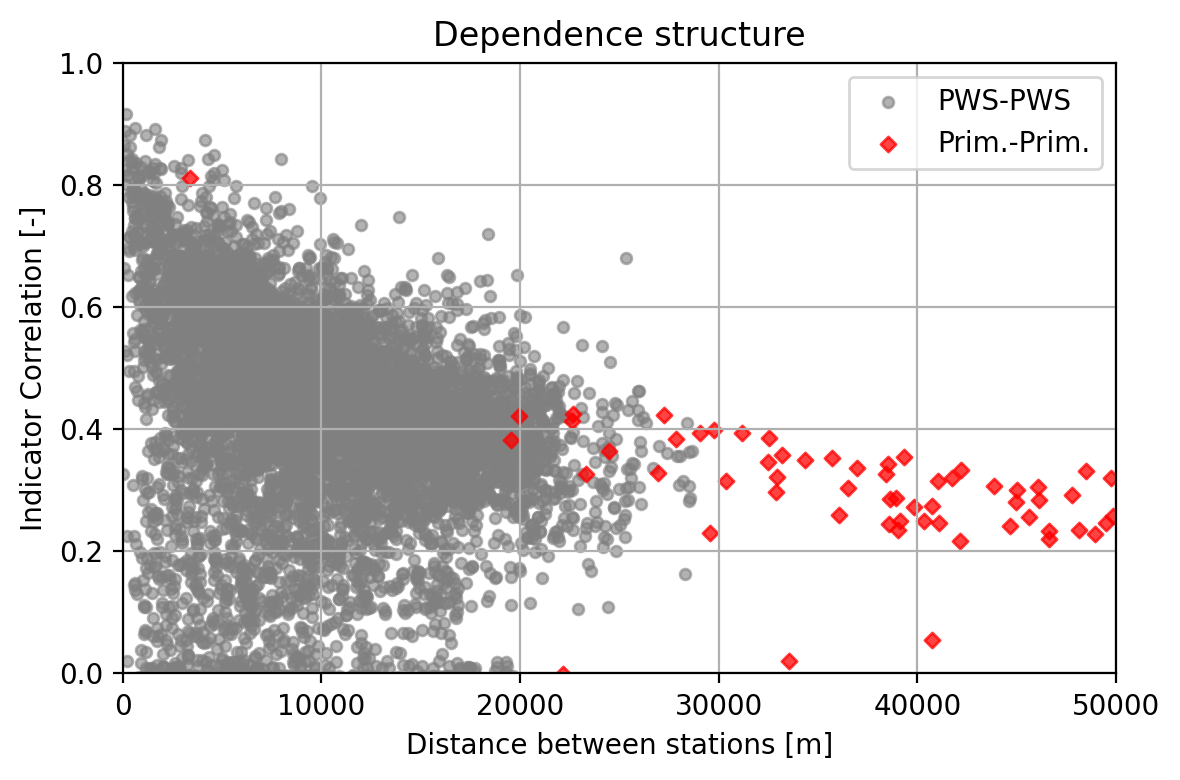

In [13]:
# PLOT indicator correlation values different networks
# calculate indicator correlation primary network
print('Calculating indicator correlation')
dist_prim, corr_prim = pws_pyqc.calc_indic_corr_all_stns(
                             coords_stns_xy=prim_coords_xy,
                             pcp_vals=in_primary_pcp.values, prob=0.99)

# calculate indicator correlation second primary network
dist_prim2, corr_prim2 = pws_pyqc.calc_indic_corr_all_stns(
    coords_stns_xy=prim_coords_xy_2,
    pcp_vals=in_primary_pcp_2.values, prob=0.99)

# claculate indicator correlation PWS-PWS
dist_pws, corr_pws = pws_pyqc.calc_indic_corr_all_stns(
                    coords_stns_xy=pws_coords_xy,
                         pcp_vals=df_pws_pcp_hourly.values)

# plot indicator correlations
pws_pyqc.plot_indic_coor(dist_prim=dist_prim,
                corr_prim=corr_prim,
                dist_pws=dist_pws,
               corr_pws=corr_pws)

We can see that there is a large gap up to 20 km in the primary network, hence there's information about the spatial structure missing. This is the reason why the data from the KMNI gauge adjusted radar product are used in addtion

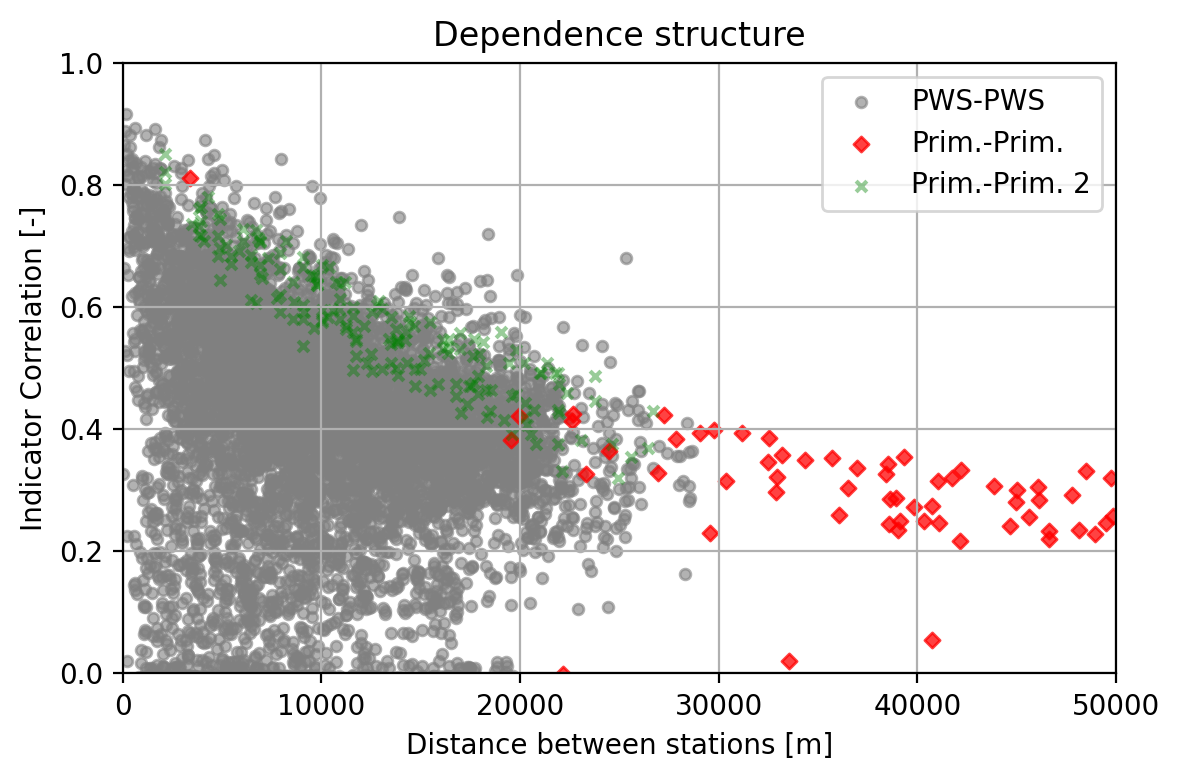

In [14]:

# additional parameters are 'dist_prim2' and 'corr_prim2'
pws_pyqc.plot_indic_coor(dist_prim=dist_prim,
                corr_prim=corr_prim,
                dist_pws=dist_pws,
               corr_pws=corr_pws,
               dist_prim2=dist_prim2,
               corr_prim2=corr_prim2)


As can be seen in the plot above, the primary stations have a certain dependence sturcture over distance. Most of the PWS as well, but there are also some PWS which do not follow this structure. When the indicator corrleation of a PWS next to a primary station is low, then it is likley that the PWS data are faulty. The first QC-filter pf PWS-pyqc now removes all PWS which do not show indicator correlations similiar to that of the reference data (primary stations).

### Applying the Indicator correlation based filter¶

100%|██████████| 134/134 [00:55<00:00,  2.39it/s]


Total Accepted 85 134


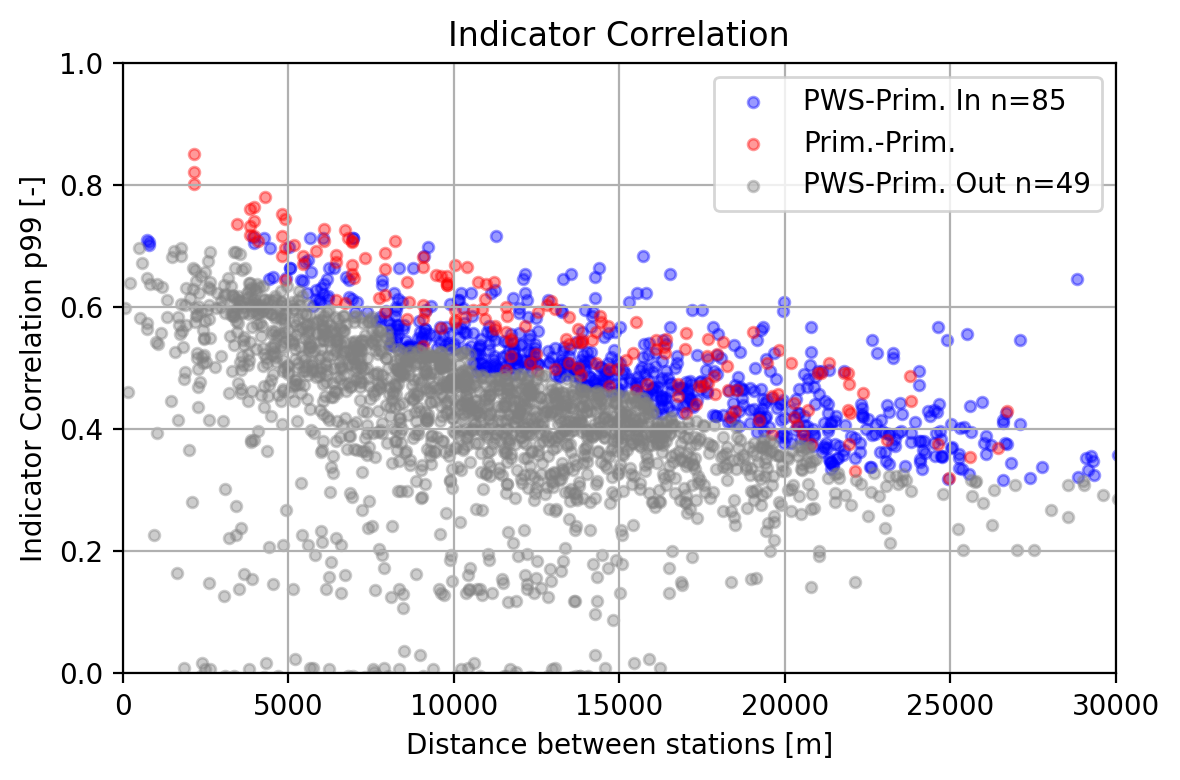

In [15]:
# apply indicator filter (using primary stations 2)

stn_in = pws_pyqc.indicator_filter(xy_net=pws_coords_xy,
                 prc_net=df_pws_pcp_hourly,
                 xy_dwd=prim_coords_xy_2,
                 prc_dwd=in_primary_pcp_2,
                     prob=0.99, max_distance=max_distance,
                     min_req_ppt_vals=2*24*30, show_plot=True,
                     fn_figure='Indicator Correlation',
                     save_folder=None,
                    tolerance=.99)

# what data type is stn_in
# Was ist tolerance? (1 muss größer als min) Parameter zum aus probieren

In [16]:
# list the accepted stations
pws_ids_accepted = df_pws_pcp_hourly.columns[np.where(stn_in==True)]
pws_ids_accepted

Index(['ams1', 'ams2', 'ams3', 'ams4', 'ams5', 'ams6', 'ams7', 'ams8', 'ams9',
       'ams10', 'ams12', 'ams13', 'ams14', 'ams15', 'ams17', 'ams18', 'ams19',
       'ams20', 'ams21', 'ams23', 'ams24', 'ams26', 'ams28', 'ams29', 'ams30',
       'ams31', 'ams32', 'ams33', 'ams34', 'ams35', 'ams36', 'ams39', 'ams40',
       'ams43', 'ams47', 'ams51', 'ams52', 'ams53', 'ams54', 'ams56', 'ams57',
       'ams62', 'ams65', 'ams66', 'ams69', 'ams71', 'ams72', 'ams75', 'ams78',
       'ams79', 'ams81', 'ams82', 'ams86', 'ams88', 'ams89', 'ams90', 'ams91',
       'ams94', 'ams95', 'ams96', 'ams98', 'ams100', 'ams101', 'ams102',
       'ams103', 'ams104', 'ams106', 'ams107', 'ams108', 'ams109', 'ams111',
       'ams113', 'ams114', 'ams115', 'ams117', 'ams118', 'ams120', 'ams123',
       'ams125', 'ams128', 'ams129', 'ams131', 'ams132', 'ams133', 'ams134'],
      dtype='object')

## 3. Bias Correction

PWS can over- or undererstimate the precepitation compared to a professional refernce station (panel b) in figure below). The reasons herefore are mayfold (c.f. Introduction). The goal is to correct the PWS distribution function usind the distribution function of neighbouring primary network stations. For more details see [Bárdossy et al. (2021)](https://doi.org/10.5194/hess-25-583-2021)

<img src="./pics/bias.png" alt="drawing" width="800"/>


### Basic Scheme of the PWS-pyqc Bias Correction


<img src="./pics/bias_correction.png" alt="drawing" width="400"/>

In [17]:
# run bias corrections for all stations - this takes a while (~lunch break)
# hint: you can save the output dataframe and work with it afterwards
df_pws_bias_corrected = pws_pyqc.bias_corr_pws_cdf(df_pws_raw=df_pws_pcp_hourly,
                        pws_ids_accepted=pws_ids_accepted,
                        df_pws_coords=df_pws_coords,                            
                        prim_coords_xy_2=prim_coords_xy_2,
                        in_primary_pcp_2=in_primary_pcp_2,
                        df_prim_coords_2=df_prim_coords_2,
                        nstns_correct=len(pws_ids_accepted),
                        plot_figures=False,
                        ppt_min_thr_0_vals=0.1,  # below it all values get p0/2
                        min_qt_to_correct=0.9)

100%|██████████| 20/20 [00:00<00:00, 51.12it/s]


Done converting primary network precipitaiton to quantile
Correcting  ams1 :  0 / 85
PWS DF shape to correct:  1405


  0%|          | 0/1405 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns)
100%|██████████| 1405/1405 [01:52<00:00, 12.52it/s]


Needed time (s) 112.27
Correcting  ams2 :  1 / 85
PWS DF shape to correct:  1384


  0%|          | 0/1384 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns)
100%|██████████| 1384/1384 [01:44<00:00, 13.21it/s]


Needed time (s) 104.81
Correcting  ams3 :  2 / 85
PWS DF shape to correct:  1367


  0%|          | 0/1367 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns)
100%|██████████| 1367/1367 [01:40<00:00, 13.66it/s]


Needed time (s) 100.08
Correcting  ams4 :  3 / 85
PWS DF shape to correct:  1081


  0%|          | 0/1081 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns)
100%|██████████| 1081/1081 [01:20<00:00, 13.42it/s]


Needed time (s) 80.61
Correcting  ams5 :  4 / 85
PWS DF shape to correct:  1189


  0%|          | 0/1189 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns)
100%|██████████| 1189/1189 [01:31<00:00, 12.99it/s]


Needed time (s) 91.58
Correcting  ams6 :  5 / 85
PWS DF shape to correct:  1290


  0%|          | 0/1290 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1290/1290 [00:48<00:00, 26.53it/s]


Needed time (s) 48.65
Correcting  ams7 :  6 / 85
PWS DF shape to correct:  1214


  0%|          | 0/1214 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1214/1214 [00:37<00:00, 32.11it/s]


Needed time (s) 37.83
Correcting  ams8 :  7 / 85
PWS DF shape to correct:  1563


  0%|          | 0/1563 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1563/1563 [00:47<00:00, 32.70it/s]


Needed time (s) 47.81
Correcting  ams9 :  8 / 85
PWS DF shape to correct:  1070


  0%|          | 0/1070 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1070/1070 [00:32<00:00, 32.98it/s]


Needed time (s) 32.47
Correcting  ams10 :  9 / 85
PWS DF shape to correct:  185


  0%|          | 0/185 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 185/185 [00:05<00:00, 33.11it/s]


Needed time (s) 5.59
Correcting  ams12 :  10 / 85
PWS DF shape to correct:  1029


  0%|          | 0/1029 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1029/1029 [00:31<00:00, 32.38it/s]


Needed time (s) 31.8
Correcting  ams13 :  11 / 85
PWS DF shape to correct:  1426


  0%|          | 0/1426 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1426/1426 [00:45<00:00, 31.30it/s]


Needed time (s) 45.56
Correcting  ams14 :  12 / 85
PWS DF shape to correct:  1456


  0%|          | 0/1456 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1456/1456 [00:46<00:00, 31.51it/s]


Needed time (s) 46.22
Correcting  ams15 :  13 / 85
PWS DF shape to correct:  1247


  0%|          | 0/1247 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1247/1247 [00:37<00:00, 33.61it/s]


Needed time (s) 37.14
Correcting  ams17 :  14 / 85
PWS DF shape to correct:  1330


  0%|          | 0/1330 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1330/1330 [00:42<00:00, 31.55it/s]


Needed time (s) 42.17
Correcting  ams18 :  15 / 85
PWS DF shape to correct:  1515


  0%|          | 0/1515 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1515/1515 [00:44<00:00, 33.85it/s]


Needed time (s) 44.78
Correcting  ams19 :  16 / 85
PWS DF shape to correct:  1386


  0%|          | 0/1386 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1386/1386 [00:42<00:00, 32.84it/s]


Needed time (s) 42.23
Correcting  ams20 :  17 / 85
PWS DF shape to correct:  1132


  0%|          | 0/1132 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1132/1132 [00:34<00:00, 32.67it/s]


Needed time (s) 34.66
Correcting  ams21 :  18 / 85
PWS DF shape to correct:  1540


  0%|          | 0/1540 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1540/1540 [00:46<00:00, 33.11it/s]


Needed time (s) 46.52
Correcting  ams23 :  19 / 85
PWS DF shape to correct:  1573


  0%|          | 0/1573 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1573/1573 [00:45<00:00, 34.59it/s]


Needed time (s) 45.52
Correcting  ams24 :  20 / 85
PWS DF shape to correct:  1497


  0%|          | 0/1497 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1497/1497 [00:45<00:00, 33.18it/s]


Needed time (s) 45.16
Correcting  ams26 :  21 / 85
PWS DF shape to correct:  1431


  0%|          | 0/1431 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1431/1431 [00:41<00:00, 34.44it/s]


Needed time (s) 41.55
Correcting  ams28 :  22 / 85
PWS DF shape to correct:  1489


  0%|          | 0/1489 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1489/1489 [00:44<00:00, 33.52it/s]


Needed time (s) 44.43
Correcting  ams29 :  23 / 85
PWS DF shape to correct:  1371


  0%|          | 0/1371 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1371/1371 [00:40<00:00, 34.03it/s]


Needed time (s) 40.31
Correcting  ams30 :  24 / 85
PWS DF shape to correct:  1404


  0%|          | 0/1404 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1404/1404 [00:41<00:00, 33.50it/s]


Needed time (s) 41.92
Correcting  ams31 :  25 / 85
PWS DF shape to correct:  1403


  0%|          | 0/1403 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1403/1403 [00:40<00:00, 34.66it/s]


Needed time (s) 40.48
Correcting  ams32 :  26 / 85
PWS DF shape to correct:  1288


  0%|          | 0/1288 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1288/1288 [00:36<00:00, 34.98it/s]


Needed time (s) 36.83
Correcting  ams33 :  27 / 85
PWS DF shape to correct:  576


  0%|          | 0/576 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 576/576 [00:16<00:00, 34.14it/s]


Needed time (s) 16.9
Correcting  ams34 :  28 / 85
PWS DF shape to correct:  1422


  0%|          | 0/1422 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1422/1422 [00:42<00:00, 33.64it/s]


Needed time (s) 42.27
Correcting  ams35 :  29 / 85
PWS DF shape to correct:  1375


  0%|          | 0/1375 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1375/1375 [00:39<00:00, 35.04it/s]


Needed time (s) 39.25
Correcting  ams36 :  30 / 85
PWS DF shape to correct:  155


  0%|          | 0/155 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 155/155 [00:04<00:00, 36.40it/s]


Needed time (s) 4.27
Correcting  ams39 :  31 / 85
PWS DF shape to correct:  1156


  0%|          | 0/1156 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1156/1156 [00:32<00:00, 35.13it/s]


Needed time (s) 32.93
Correcting  ams40 :  32 / 85
PWS DF shape to correct:  633


  0%|          | 0/633 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 633/633 [00:18<00:00, 33.41it/s]


Needed time (s) 19.0
Correcting  ams43 :  33 / 85
PWS DF shape to correct:  717


  0%|          | 0/717 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 717/717 [00:21<00:00, 32.71it/s]


Needed time (s) 21.95
Correcting  ams47 :  34 / 85
PWS DF shape to correct:  1039


  0%|          | 0/1039 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1039/1039 [00:32<00:00, 32.28it/s]


Needed time (s) 32.21
Correcting  ams51 :  35 / 85
PWS DF shape to correct:  696


  0%|          | 0/696 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 696/696 [00:27<00:00, 25.60it/s]


Needed time (s) 27.24
Correcting  ams52 :  36 / 85
PWS DF shape to correct:  1301


  0%|          | 0/1301 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1301/1301 [00:52<00:00, 24.74it/s]


Needed time (s) 52.62
Correcting  ams53 :  37 / 85
PWS DF shape to correct:  1438


  0%|          | 0/1438 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1438/1438 [00:45<00:00, 31.73it/s]


Needed time (s) 45.33
Correcting  ams54 :  38 / 85
PWS DF shape to correct:  1506


  0%|          | 0/1506 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1506/1506 [00:47<00:00, 31.70it/s]


Needed time (s) 47.54
Correcting  ams56 :  39 / 85
PWS DF shape to correct:  809


  0%|          | 0/809 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 809/809 [00:27<00:00, 29.21it/s]


Needed time (s) 27.71
Correcting  ams57 :  40 / 85
PWS DF shape to correct:  783


  0%|          | 0/783 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 783/783 [00:25<00:00, 30.45it/s]


Needed time (s) 25.75
Correcting  ams62 :  41 / 85
PWS DF shape to correct:  439


  0%|          | 0/439 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 439/439 [00:14<00:00, 29.44it/s]


Needed time (s) 14.92
Correcting  ams65 :  42 / 85
PWS DF shape to correct:  1163


  0%|          | 0/1163 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1163/1163 [00:35<00:00, 32.83it/s]


Needed time (s) 35.44
Correcting  ams66 :  43 / 85
PWS DF shape to correct:  253


  0%|          | 0/253 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 253/253 [00:07<00:00, 33.18it/s]


Needed time (s) 7.65
Correcting  ams69 :  44 / 85
PWS DF shape to correct:  479


  0%|          | 0/479 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 479/479 [00:14<00:00, 33.74it/s]


Needed time (s) 14.21
Correcting  ams71 :  45 / 85
PWS DF shape to correct:  788


  0%|          | 0/788 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 788/788 [00:23<00:00, 32.93it/s]


Needed time (s) 23.95
Correcting  ams72 :  46 / 85
PWS DF shape to correct:  1264


  0%|          | 0/1264 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1264/1264 [00:38<00:00, 33.20it/s]


Needed time (s) 38.09
Correcting  ams75 :  47 / 85
PWS DF shape to correct:  973


  0%|          | 0/973 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 973/973 [00:27<00:00, 35.10it/s]


Needed time (s) 27.74
Correcting  ams78 :  48 / 85
PWS DF shape to correct:  1332


  0%|          | 0/1332 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1332/1332 [00:39<00:00, 34.12it/s]


Needed time (s) 39.07
Correcting  ams79 :  49 / 85
PWS DF shape to correct:  1338


  0%|          | 0/1338 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1338/1338 [00:38<00:00, 34.47it/s]


Needed time (s) 38.81
Correcting  ams81 :  50 / 85
PWS DF shape to correct:  1138


  0%|          | 0/1138 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1138/1138 [00:34<00:00, 33.46it/s]


Needed time (s) 34.02
Correcting  ams82 :  51 / 85
PWS DF shape to correct:  934


  0%|          | 0/934 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 934/934 [00:27<00:00, 34.58it/s]


Needed time (s) 27.01
Correcting  ams86 :  52 / 85
PWS DF shape to correct:  1239


  0%|          | 0/1239 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1239/1239 [00:38<00:00, 31.87it/s]


Needed time (s) 38.91
Correcting  ams88 :  53 / 85
PWS DF shape to correct:  1376


  0%|          | 0/1376 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1376/1376 [00:44<00:00, 31.17it/s]


Needed time (s) 44.16
Correcting  ams89 :  54 / 85
PWS DF shape to correct:  182


  0%|          | 0/182 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 182/182 [00:05<00:00, 30.51it/s]


Needed time (s) 5.98
Correcting  ams90 :  55 / 85
PWS DF shape to correct:  1300


  0%|          | 0/1300 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1300/1300 [00:48<00:00, 26.89it/s]


Needed time (s) 48.36
Correcting  ams91 :  56 / 85
PWS DF shape to correct:  671


  0%|          | 0/671 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 671/671 [00:26<00:00, 25.19it/s]


Needed time (s) 26.66
Correcting  ams94 :  57 / 85
PWS DF shape to correct:  1072


  0%|          | 0/1072 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1072/1072 [00:43<00:00, 24.57it/s]


Needed time (s) 43.64
Correcting  ams95 :  58 / 85
PWS DF shape to correct:  460


  0%|          | 0/460 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 460/460 [00:16<00:00, 28.57it/s]


Needed time (s) 16.12
Correcting  ams96 :  59 / 85
PWS DF shape to correct:  168


  0%|          | 0/168 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 168/168 [00:06<00:00, 27.90it/s]


Needed time (s) 6.03
Correcting  ams98 :  60 / 85
PWS DF shape to correct:  784


  0%|          | 0/784 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 784/784 [00:32<00:00, 24.17it/s]


Needed time (s) 32.46
Correcting  ams100 :  61 / 85
PWS DF shape to correct:  1232


  0%|          | 0/1232 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1232/1232 [00:50<00:00, 24.26it/s]


Needed time (s) 50.8
Correcting  ams101 :  62 / 85
PWS DF shape to correct:  222


  0%|          | 0/222 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 222/222 [00:07<00:00, 29.57it/s]


Needed time (s) 7.53
Correcting  ams102 :  63 / 85
PWS DF shape to correct:  714


  0%|          | 0/714 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 714/714 [00:26<00:00, 26.63it/s]


Needed time (s) 26.84
Correcting  ams103 :  64 / 85
PWS DF shape to correct:  1484


  0%|          | 0/1484 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1484/1484 [00:56<00:00, 26.31it/s]


Needed time (s) 56.43
Correcting  ams104 :  65 / 85
PWS DF shape to correct:  128


  0%|          | 0/128 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 128/128 [00:05<00:00, 24.40it/s]


Needed time (s) 5.27
Correcting  ams106 :  66 / 85
PWS DF shape to correct:  1368


  0%|          | 0/1368 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1368/1368 [00:59<00:00, 23.12it/s]


Needed time (s) 59.19
Correcting  ams107 :  67 / 85
PWS DF shape to correct:  1593


  0%|          | 0/1593 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1593/1593 [01:10<00:00, 22.73it/s]


Needed time (s) 70.1
Correcting  ams108 :  68 / 85
PWS DF shape to correct:  1581


  0%|          | 0/1581 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1581/1581 [01:15<00:00, 21.05it/s]


Needed time (s) 75.13
Correcting  ams109 :  69 / 85
PWS DF shape to correct:  266


  0%|          | 0/266 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 266/266 [00:12<00:00, 20.48it/s]


Needed time (s) 13.01
Correcting  ams111 :  70 / 85
PWS DF shape to correct:  862


  0%|          | 0/862 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 862/862 [00:44<00:00, 19.39it/s]


Needed time (s) 44.48
Correcting  ams113 :  71 / 85
PWS DF shape to correct:  328


  0%|          | 0/328 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 328/328 [00:14<00:00, 21.98it/s]


Needed time (s) 14.94
Correcting  ams114 :  72 / 85
PWS DF shape to correct:  922


  0%|          | 0/922 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 922/922 [00:41<00:00, 22.14it/s]


Needed time (s) 41.66
Correcting  ams115 :  73 / 85
PWS DF shape to correct:  1346


  0%|          | 0/1346 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1346/1346 [01:01<00:00, 21.78it/s]


Needed time (s) 61.84
Correcting  ams117 :  74 / 85
PWS DF shape to correct:  975


  0%|          | 0/975 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 975/975 [00:43<00:00, 22.32it/s]


Needed time (s) 43.7
Correcting  ams118 :  75 / 85
PWS DF shape to correct:  269


  0%|          | 0/269 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 269/269 [00:11<00:00, 24.03it/s]


Needed time (s) 11.22
Correcting  ams120 :  76 / 85
PWS DF shape to correct:  750


  0%|          | 0/750 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 750/750 [00:30<00:00, 25.00it/s]


Needed time (s) 30.03
Correcting  ams123 :  77 / 85
PWS DF shape to correct:  1505


  0%|          | 0/1505 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1505/1505 [01:01<00:00, 24.33it/s]


Needed time (s) 61.89
Correcting  ams125 :  78 / 85
PWS DF shape to correct:  983


  0%|          | 0/983 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 983/983 [00:33<00:00, 29.69it/s]


Needed time (s) 33.13
Correcting  ams128 :  79 / 85
PWS DF shape to correct:  1152


  0%|          | 0/1152 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1152/1152 [00:47<00:00, 24.41it/s]


Needed time (s) 47.22
Correcting  ams129 :  80 / 85
PWS DF shape to correct:  153


  0%|          | 0/153 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 153/153 [00:06<00:00, 24.06it/s]


Needed time (s) 6.38
Correcting  ams131 :  81 / 85
PWS DF shape to correct:  328


  0%|          | 0/328 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 328/328 [00:14<00:00, 22.49it/s]


Needed time (s) 14.61
Correcting  ams132 :  82 / 85
PWS DF shape to correct:  641


  0%|          | 0/641 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 641/641 [00:24<00:00, 26.34it/s]


Needed time (s) 24.36
Correcting  ams133 :  83 / 85
PWS DF shape to correct:  831


  0%|          | 0/831 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 831/831 [00:31<00:00, 26.29it/s]


Needed time (s) 31.63
Correcting  ams134 :  84 / 85
PWS DF shape to correct:  1469


  0%|          | 0/1469 [00:00<?, ?it/s]C:\Users\Abbas\Documents\Opensense\notebooks\PWSpyqcFunctions.py:1019: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  prim_edf_vals = pd.Series(index=prim_ppt_neigbrs_nonan.columns, dtype='float64')
100%|██████████| 1469/1469 [00:59<00:00, 24.68it/s]

Needed time (s) 59.55


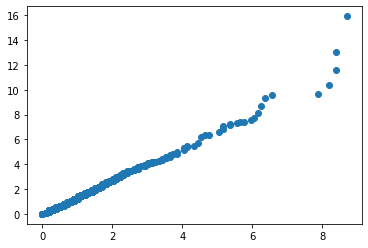

In [19]:
# Example of corrected pws
plt.scatter(df_pws_pcp_hourly.iloc[:, 0],
            df_pws_bias_corrected.iloc[:, 0])

## 4. Apply On-Event filter 

The goal is to correct the PWS values (false zeros) and (false high values)
[Bárdossy et al. (2021)](https://doi.org/10.5194/hess-25-583-2021)

[El Hachem et at. (2022)](https://doi.org/10.5194/hess-26-6137-2022)

In [82]:


df_pws_flagged = pws_pyqc.on_event_filter(df_pws=df_pws_bias_corrected, 
                               df_prim=in_primary_pcp_2, 
                               df_pws_coords=df_pws_coords,
                               df_prim_coords=df_prim_coords_2)

320it [00:00, 544.82it/s]

pws good 59
pws outlier 1
flaggind time step 2016-05-12 15:00:00
flagged values 2.32 min prim 0.0 max prim 0.1799999922513961
pws good 65
pws outlier 1
flaggind time step 2016-05-14 11:00:00
flagged values 0.1 min prim 0.0 max prim 0.1899999976158142
pws good 65
pws outlier 1
pws good 63
pws outlier 2
flaggind time step 2016-05-15 03:00:00
flagged values 0.1 min prim 0.0 max prim 0.1199999973177909
flaggind time step 2016-05-15 03:00:00
flagged values 0.1 min prim 0.0 max prim 0.1199999973177909
pws good 64
pws outlier 1
flaggind time step 2016-05-15 10:00:00
flagged values 0.17 min prim 0.0 max prim 0.4099999964237213


422it [00:00, 412.00it/s]

pws good 66
pws outlier 1
flaggind time step 2016-05-16 02:00:00
flagged values 0.1 min prim 0.0 max prim 0.2199999988079071
pws good 62
pws outlier 1
flaggind time step 2016-05-16 06:00:00
flagged values 1.03 min prim 0.0 max prim 0.1299999952316284


512it [00:01, 405.68it/s]

pws good 62
pws outlier 2
flaggind time step 2016-05-20 03:00:00
flagged values 0.1 min prim 0.0 max prim 0.7699999809265137
flaggind time step 2016-05-20 03:00:00
flagged values 0.1 min prim 0.0 max prim 0.7699999809265137
pws good 60
pws outlier 10
flaggind time step 2016-05-20 04:00:00
flagged values 0.1 min prim 0.0 max prim 0.3700000047683716
flaggind time step 2016-05-20 04:00:00
flagged values 0.1 min prim 0.0 max prim 0.3700000047683716
pws good 66
pws outlier 1
flaggind time step 2016-05-21 23:00:00
flagged values 6.36 min prim 0.0 max prim 0.1099999994039535


655it [00:01, 435.38it/s]

pws good 68
pws outlier 1
pws good 68
pws outlier 2
flaggind time step 2016-05-25 06:00:00
flagged values 0.1 min prim 0.0 max prim 0.1899999976158142


701it [00:01, 435.33it/s]

pws good 67
pws outlier 1
flaggind time step 2016-05-28 12:00:00
flagged values 5.76 min prim 0.0 max prim 0.2299999892711639
pws good 64
pws outlier 1
pws good 63
pws outlier 5
flaggind time step 2016-05-30 00:00:00
flagged values 0.1 min prim 0.0 max prim 0.1199999973177909
flaggind time step 2016-05-30 00:00:00
flagged values 0.1 min prim 0.0 max prim 0.1199999973177909
flaggind time step 2016-05-30 00:00:00
flagged values 0.1 min prim 0.0 max prim 0.1199999973177909
flaggind time step 2016-05-30 00:00:00
flagged values 0.1 min prim 0.0 max prim 0.1199999973177909
pws good 70
pws outlier 2
flaggind time step 2016-05-30 07:00:00
flagged values 0.81 min prim 0.0 max prim 0.1499999910593032
flaggind time step 2016-05-30 07:00:00
flagged values 0.1 min prim 0.0 max prim 0.1499999910593032
pws good 68
pws outlier 1
flaggind time step 2016-06-01 05:00:00
flagged values 12.12 min prim 0.0 max prim 

802it [00:01, 444.55it/s]

0.2599999904632568
pws good 66
pws outlier 1
flaggind time step 2016-06-02 18:00:00
flagged values 25.45 min prim 0.0 max prim 1.579999923706055
pws good 64
pws outlier 1
flaggind time step 2016-06-02 20:00:00
flagged values 0.1 min prim 0.0 max prim 0.7699999809265137
pws good 65
pws outlier 1
flaggind time step 2016-06-02 21:00:00
flagged values 0.1 min prim 0.0 max prim 0.4399999976158142


1058it [00:02, 376.97it/s]

pws good 65
pws outlier 2
flaggind time step 2016-06-12 13:00:00
flagged values 10.91 min prim 0.0 max prim 0.1099999994039535
pws good 55
pws outlier 10
flaggind time step 2016-06-13 02:00:00
flagged values 0.1 min prim 0.0 max prim 0.2199999988079071
flaggind time step 2016-06-13 02:00:00
flagged values 0.1 min prim 0.0 max prim 0.2199999988079071
flaggind time step 2016-06-13 02:00:00
flagged values 0.1 min prim 0.0 max prim 0.2199999988079071
flaggind time step 2016-06-13 02:00:00
flagged values 0.1 min prim 0.0 max prim 0.2199999988079071
flaggind time step 2016-06-13 02:00:00
flagged values 0.1 min prim 0.0 max prim 0.2199999988079071
flaggind time step 2016-06-13 02:00:00
flagged values 0.1 min prim 0.0 max prim 0.2199999988079071
flaggind time step 2016-06-13 02:00:00
flagged values 124.74 min prim 0.0 max prim 0.2199999988079071
flaggind time step 2016-06-13 02:00:00
flagged values 0.1 min prim 0.0 max prim 0.2199999988079071
pws good 63
pws outlier 2
flaggind time step 2016-0

1175it [00:02, 361.85it/s]

pws good 64
pws outlier 1
flaggind time step 2016-06-15 23:00:00
flagged values 84.84 min prim 0.0 max prim 0.1199999973177909
pws good 68
pws outlier 1
flaggind time step 2016-06-16 13:00:00
flagged values 6.46 min prim 0.0 max prim 0.6800000071525574
pws good 66
pws outlier 1
flaggind time step 2016-06-16 16:00:00
flagged values 2.24 min prim 0.0 max prim 0.1799999922513961
pws good 63
pws outlier 1
flaggind time step 2016-06-16 17:00:00
flagged values 86.05 min prim 0.0 max prim 1.7999999523162842
pws good 68
pws outlier 2
flaggind time step 2016-06-16 20:00:00
flagged values 103.02 min prim 0.0 max prim 1.9299999475479128
flaggind time step 2016-06-16 20:00:00
flagged values 0.1 min prim 0.0 max prim 1.9299999475479128
pws good 64
pws outlier 1
flaggind time step 2016-06-18 20:00:00
flagged values 213.31 min prim 0.0 max prim 0.5399999618530273


1250it [00:03, 367.04it/s]

pws good 69
pws outlier 3
flaggind time step 2016-06-20 08:00:00
flagged values 0.1 min prim 0.0 max prim 0.2899999916553497
pws good 62
pws outlier 4
flaggind time step 2016-06-20 17:00:00
flagged values 0.1 min prim 0.0 max prim 1.5
pws good 68
pws outlier 1
flaggind time step 2016-06-21 15:00:00
flagged values 1.21 min prim 0.0 max prim 0.2699999809265136
pws good 68
pws outlier 1
flaggind time step 2016-06-21 17:00:00
flagged values 0.1 min prim 0.0 max prim 1.75


1428it [00:03, 395.10it/s]

pws good 69
pws outlier 1
flaggind time step 2016-06-27 06:00:00
flagged values 0.1 min prim 0.0 max prim 0.1499999910593032
pws good 71
pws outlier 1
flaggind time step 2016-06-27 13:00:00
flagged values 0.1 min prim 0.0 max prim 0.5
pws good 71
pws outlier 2
flaggind time step 2016-06-28 17:00:00
flagged values 0.1 min prim 0.0 max prim 4.630000114440918
pws good 70
pws outlier 1
flaggind time step 2016-06-28 19:00:00
flagged values 0.1 min prim 0.0 max prim 5.319999694824219
pws good 64
pws outlier 2
flaggind time step 2016-06-29 00:00:00
flagged values 0.1 min prim 0.0 max prim 0.1299999952316284
pws good 59
pws outlier 8
flaggind time step 2016-06-29 01:00:00
flagged values 0.4 min prim 0.0 max prim 0.1299999952316284
flaggind time step 2016-06-29 01:00:00
flagged values 0.1 min prim 0.0 max prim 0.1299999952316284
flaggind time step 2016-06-29 01:00:00
flagged values 0.1 min prim 0.0 max prim 0.1299999952316284
flaggind time step 2016-06-29 01:00:00
flagged values 0.12 min prim 0

1468it [00:03, 369.61it/s]

pws good 68
pws outlier 1
flaggind time step 2016-06-30 06:00:00
flagged values 0.1 min prim 0.0 max prim 0.3100000023841858
pws good 63
pws outlier 6
flaggind time step 2016-06-30 07:00:00
flagged values 0.1 min prim 0.0 max prim 0.8899999856948853
flaggind time step 2016-06-30 07:00:00
flagged values 0.1 min prim 0.0 max prim 0.8899999856948853
flaggind time step 2016-06-30 07:00:00
flagged values 0.1 min prim 0.0 max prim 0.8899999856948853
flaggind time step 2016-06-30 07:00:00
flagged values 0.1 min prim 0.0 max prim 0.8899999856948853
pws good 64
pws outlier 4
flaggind time step 2016-07-01 03:00:00
flagged values 0.1 min prim 0.0 max prim 0.1299999952316284
flaggind time step 2016-07-01 03:00:00
flagged values 0.1 min prim 0.0 max prim 0.1299999952316284
flaggind time step 2016-07-01 03:00:00
flagged values 0.1 min prim 0.0 max prim 0.1299999952316284
flaggind time step 2016-07-01 03:00:00
flagged values 0.1 min prim 0.0 max prim 0.1299999952316284
pws good 70
pws outlier 2
flagg

1542it [00:03, 332.43it/s]

pws good 67
pws outlier 1
flaggind time step 2016-07-03 04:00:00
flagged values 0.1 min prim 0.0 max prim 1.2599999904632568
pws good 65
pws outlier 2
flaggind time step 2016-07-03 05:00:00
flagged values 0.1 min prim 0.0 max prim 3.0999999046325684
flaggind time step 2016-07-03 05:00:00
flagged values 0.1 min prim 0.0 max prim 3.0999999046325684
pws good 70
pws outlier 1
flaggind time step 2016-07-03 06:00:00
flagged values 0.1 min prim 0.0 max prim 7.109999656677246
pws good 67
pws outlier 1
flaggind time step 2016-07-03 07:00:00
flagged values 0.69 min prim 0.0 max prim 0.1199999973177909
pws good 69
pws outlier 3
flaggind time step 2016-07-03 08:00:00
flagged values 0.1 min prim 0.0 max prim 0.6200000047683716
flaggind time step 2016-07-03 08:00:00
flagged values 0.1 min prim 0.0 max prim 0.6200000047683716
flaggind time step 2016-07-03 08:00:00
flagged values 0.1 min prim 0.0 max prim 0.6200000047683716
pws good 72
pws outlier 3
flaggind time step 2016-07-05 06:00:00
flagged value

1615it [00:04, 329.96it/s]

pws good 64
pws outlier 1
flaggind time step 2016-07-05 12:00:00
flagged values 0.1 min prim 0.0 max prim 0.2599999904632568
pws good 71
pws outlier 1
flaggind time step 2016-07-05 14:00:00
flagged values 0.1 min prim 0.0 max prim 0.1400000005960464


1773it [00:04, 344.67it/s]

pws good 68
pws outlier 1
flaggind time step 2016-07-12 02:00:00
flagged values 0.1 min prim 0.0 max prim 2.190000057220459
pws good 72
pws outlier 3
flaggind time step 2016-07-12 06:00:00
flagged values 0.1 min prim 0.0 max prim 0.1199999973177909
flaggind time step 2016-07-12 06:00:00
flagged values 0.1 min prim 0.0 max prim 0.1199999973177909
flaggind time step 2016-07-12 06:00:00
flagged values 0.1 min prim 0.0 max prim 0.1199999973177909
pws good 68
pws outlier 1
flaggind time step 2016-07-13 10:00:00
flagged values 0.1 min prim 0.0 max prim 0.4799999892711639
pws good 74
pws outlier 1
flaggind time step 2016-07-14 12:00:00
flagged values 0.1 min prim 0.0 max prim 0.199999988079071


2051it [00:05, 392.87it/s]

pws good 71
pws outlier 1
flaggind time step 2016-07-23 17:00:00
flagged values 0.1 min prim 0.0 max prim 0.2399999946355819


2205it [00:05, 347.54it/s]

pws good 71
pws outlier 3
flaggind time step 2016-07-28 21:00:00
flagged values 0.1 min prim 0.0 max prim 0.2399999946355819
flaggind time step 2016-07-28 21:00:00
flagged values 0.1 min prim 0.0 max prim 0.2399999946355819
pws good 70
pws outlier 2
flaggind time step 2016-07-29 11:00:00
flagged values 0.1 min prim 0.0 max prim 1.649999976158142
flaggind time step 2016-07-29 11:00:00
flagged values 0.1 min prim 0.0 max prim 1.649999976158142
pws good 72
pws outlier 1
flaggind time step 2016-07-31 10:00:00
flagged values 0.1 min prim 0.0 max prim 4.119999885559082


2249it [00:05, 381.43it/s]

pws good 74
pws outlier 1
flaggind time step 2016-08-01 05:00:00
flagged values 1.72 min prim 0.0 max prim 0.3599999845027923
pws good 76
pws outlier 1
flaggind time step 2016-08-02 03:00:00
flagged values 0.1 min prim 0.0 max prim 0.2299999892711639
pws good 68
pws outlier 3
flaggind time step 2016-08-02 08:00:00
flagged values 0.1 min prim 0.0 max prim 0.209999993443489
flaggind time step 2016-08-02 08:00:00
flagged values 0.1 min prim 0.0 max prim 0.209999993443489
flaggind time step 2016-08-02 08:00:00
flagged values 0.17 min prim 0.0 max prim 0.209999993443489
pws good 72
pws outlier 4
flaggind time step 2016-08-02 10:00:00
flagged values 0.1 min prim 0.0 max prim 0.209999993443489
flaggind time step 2016-08-02 10:00:00
flagged values 0.1 min prim 0.0 max prim 0.209999993443489
flaggind time step 2016-08-02 10:00:00
flagged values 0.1 min prim 0.0 max prim 0.209999993443489
flaggind time step 2016-08-02 10:00:00
flagged values 0.1 min prim 0.0 max prim 0.209999993443489
pws good 6

KeyboardInterrupt: 

### Excercise:

+ Plot the original raw data for the same timestep and compare the results. Which parts int he codse do you have to change?

**Hint:** copy & paste both cells from above and replace the corresponding variables under

`#Create coordinates and data for interpolating values for a given timestamp/index` 
